# Data Cleaning 🧹🧼
### Levels dataframe
- Create a pandas dataframe for the levels of rgdpna, pop, rnna, emp and hc.
- Create additional columns in the df_levels dataframe for rgdpna_pc and rgdpna_pw
- Extract the TFP measure using a Cobb Douglas production function of the form $ Y = A K^{\alpha} L^{1-\alpha} $. We also did for the case where human capital is included.
### Growth rates dataframe
- Create a new dataframe called df_growth which includes the growth rates year on year for each variable.
- Added several new columns to the df_growth dataframe which where the proportional contributions of each variable to the total gdp growth rate.
- Resampled the df_growth dataframe for 5 and 10 year periods to get an idea of long run trends in the data.

In [2]:
# Import relevant modules
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Import custom modules (ensure they are saved in the same file as the notebook otherwise it won't import them)
import reg_functions as reg

In [3]:
# Read in the data from the Penn World Tables

df_levels = pd.read_excel("./pwt100.xlsx", sheet_name = "Data", header = 0)

#Select the country to analyse
country_selection = "Germany"

# Filter for the relevant rows and columns
df_levels = df_levels.loc[:, ("country", "year", "rgdpna", "pop", "rnna", "emp", "hc")]
df_levels = df_levels.loc[df_levels["country"] == country_selection,:]
df_levels = df_levels.reset_index(drop = True)

# Create GDP per capita and per worker
df_levels["rgdpna_pc"] = df_levels["rgdpna"] / df_levels["pop"]
df_levels["rgdpna_pw"] = df_levels["rgdpna"] / df_levels["emp"]

# Remove rows with missing data
ymax = df_levels.loc[df_levels["rgdpna"] > 0, "year"].max()
ymin = df_levels.loc[df_levels["rgdpna"] > 0, "year"].min()
df_levels = df_levels.loc[df_levels["year"] >= ymin, :]

df_levels["year"] = pd.to_datetime(df_levels["year"], format = "%Y")

In [4]:
# Extract TFP measure
alpha = 0.3  # benchmark alpha value

rnna = df_levels["rnna"]  # capital variable
emp = df_levels["emp"]  # labour variable
hc = df_levels["hc"]  # human capital variable

# tfp from cobb-douglas production function without human capital
tfp_full = df_levels["rgdpna"] / ((rnna ** alpha) * (emp ** (1 - alpha)))

# tfp from cobb-douglas production function with human capital
tfp_ex_hc = df_levels["rgdpna"] / ((rnna ** alpha) * ((hc * emp) ** (1 - alpha)))

# add new variables to the df_levels frame
df_levels["TFP_full"] = tfp_full
df_levels["TFP_ex_hc"] = tfp_ex_hc

In [5]:
# Create a second dataframe that holds the growth rates of each variable.
df_growth = df_levels.loc[:,("rgdpna", "pop", "rnna", "emp", "hc", "rgdpna_pc", "rgdpna_pw", "TFP_full", "TFP_ex_hc")].pct_change()
df_growth.insert(0, "country", country_selection)
df_growth.insert(1, "year", df_levels["year"])
df_growth = df_growth.dropna().reset_index(drop = True)

# Create the TFP/emp growth ratio data.
df_growth["TFP_full_emp_ratio"] = df_growth["TFP_full"] / df_growth["emp"]
df_growth["TFP_ex_hc_emp_ratio"] = df_growth["TFP_ex_hc"] / df_growth["emp"]

# Create the factor contributions to gdp growth data.
df_growth["TFP_full_contribution"] = df_growth["TFP_full"] / df_growth["rgdpna"]
df_growth["TFP_ex_hc_contribution"] = df_growth["TFP_ex_hc"] / df_growth["rgdpna"]
df_growth["hc_contribution"] = ((1-alpha) * df_growth["hc"]) / df_growth["rgdpna"]
df_growth["rnna_contribution"] = (alpha * df_growth["rnna"]) / df_growth["rgdpna"]
df_growth["emp_contribution"] = ((1-alpha) * df_growth["emp"]) / df_growth["rgdpna"]

# Filter out 1967 from the growth rates when calculating contributions. This is done to avoid losing the 'essence' of the data.
# The GDP growth rate in German in 1967 is very close to zero so the contributions become very large and make analysis very difficult.
if country_selection == "Germany":
    df_growth.loc[df_growth["year"] == '1967-01-01', ["TFP_ex_hc_contribution", "TFP_full_contribution", "hc_contribution", "rnna_contribution", "emp_contribution"]] = np.nan

# Resample the data for 5 and 10 year periods to get an idea of long run trends.
df_growth_5year = df_growth.resample("5Y", on = "year").mean()
df_growth_10year = df_growth.resample("10Y", on = "year").mean()

In [6]:
# Define the years of interest for both countries. 
year_of_interest = {
    "Germany": "1989",      # Fall of the Berlin Wall
    "Indonesia": "1997",    # Asian financial crisis
}

# Trend Paths 📈
- While all 4 trend paths have been tested, only the path that fit best has been left here.
- The regression functions come from the reg_functions.py file.

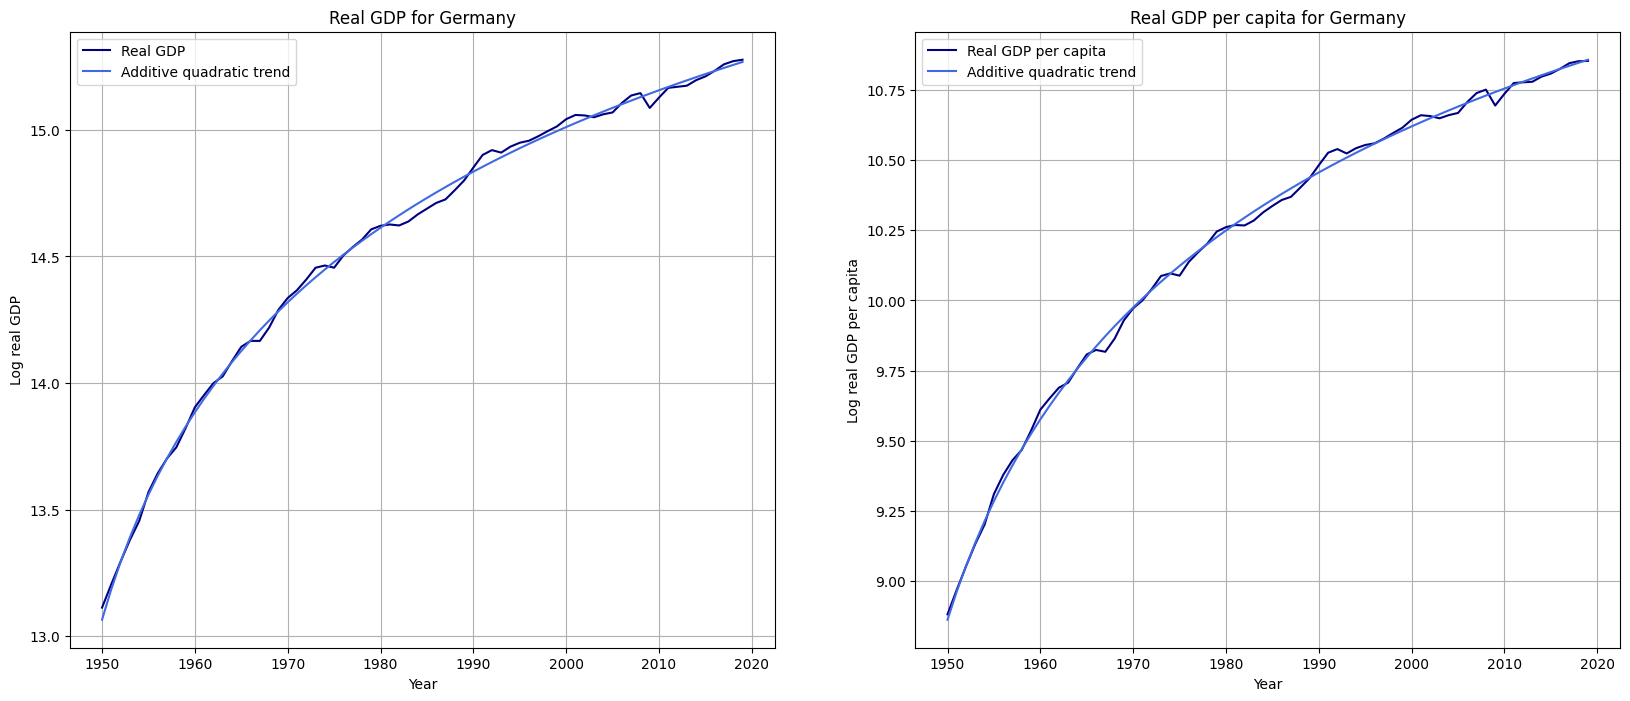

In [7]:
# Plot GDP and GDP per capita trend paths using reg_functions module 
fig = plt.figure(figsize = (20, 8))

ax1, ax2 = fig.subplots(1, 2)

ax1.plot(df_levels["year"], np.log(df_levels["rgdpna"]), label = "Real GDP", color = "navy")
ax1.plot(df_levels["year"], np.log(reg.calc_add_quad(df_levels["rgdpna"])), label = "Additive quadratic trend", color = "royalblue")
ax1.set_xlabel("Year")
ax1.set_ylabel("Log real GDP")
ax1.set_title("Real GDP for " + country_selection)
ax1.grid()
ax1.legend()

ax2.plot(df_levels["year"], np.log(df_levels["rgdpna_pc"]), label = "Real GDP per capita", color = "navy")
ax2.plot(df_levels["year"], np.log(reg.calc_add_quad(df_levels["rgdpna_pc"])), label = "Additive quadratic trend", color = "royalblue")
ax2.set_xlabel("Year")
ax2.set_ylabel("Log real GDP per capita")
ax2.set_title("Real GDP per capita for " + country_selection)
ax2.grid()
ax2.legend()

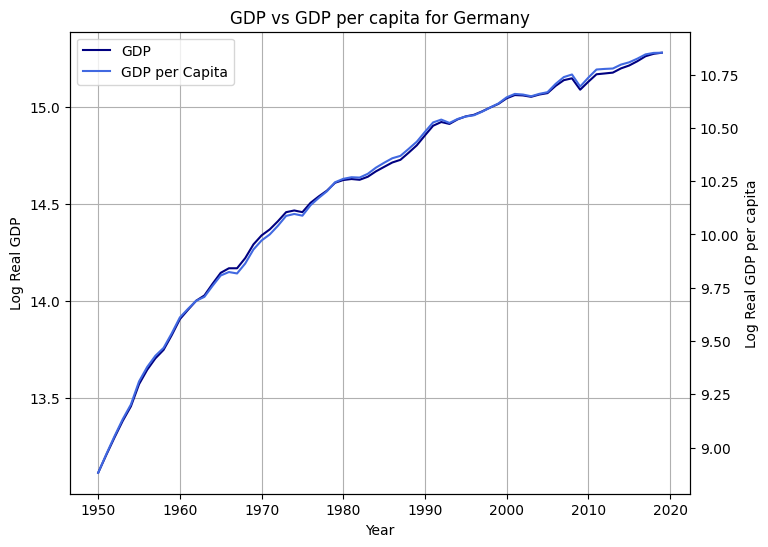

In [8]:
# Plot GDP and GDP per capita on the same graph to analyse if there is any divergence.
fig = plt.figure(figsize=(8,6))
ax1 = fig.subplots(1,1)

ax1.plot(df_levels["year"], np.log(df_levels["rgdpna"]), label="GDP", color="navy")
ax1.set_title("GDP vs GDP per capita for " + country_selection)
ax1.set_xlabel("Year")
ax1.set_ylabel("Log Real GDP")
ax1.ticklabel_format(style="plain", axis="y")
ax1.grid(True)

# Use two different y axes but share the same x axis.
ax2 = ax1.twinx()
ax2.plot(df_levels["year"], np.log(df_levels["rgdpna_pc"]), label="GDP per Capita", color="royalblue")
ax2.set_ylabel("Log Real GDP per capita")

# Combine the legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2)


# TFP Measure 💻🛠️
- **TFP including human capital** refers to the TFP measure from the model where human capital was not included as part of the production function.
- Likewise, **TFP excluding human capital** refers to the TFP measure from the model where human capital was included in the production function.

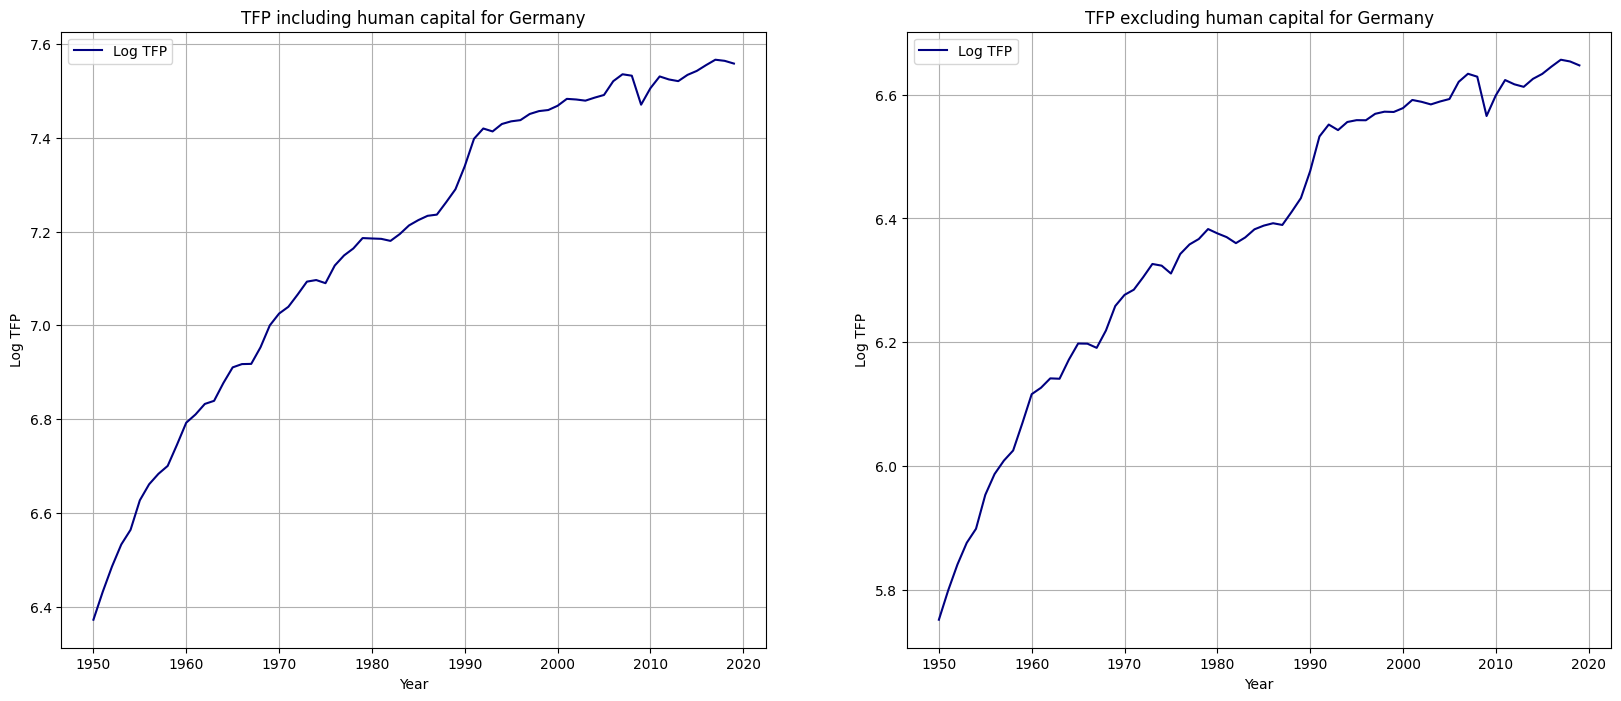

In [9]:
# Plot both TFP measures
fig = plt.figure(figsize = (20, 8))

ax1, ax2 = fig.subplots(1, 2)

ax1.plot(df_levels["year"], np.log(df_levels["TFP_full"]), label = "Log TFP", color = "navy")
ax1.set_xlabel("Year")
ax1.set_ylabel("Log TFP")
ax1.set_title("TFP including human capital for " + country_selection)
ax1.grid()
ax1.legend()

ax2.plot(df_levels["year"], np.log(df_levels["TFP_ex_hc"]), label = "Log TFP", color = "navy")
ax2.set_xlabel("Year")
ax2.set_ylabel("Log TFP")
ax2.set_title("TFP excluding human capital for " + country_selection)
ax2.grid()
ax2.legend()

# Labour Productivity 👷🏽‍♀️

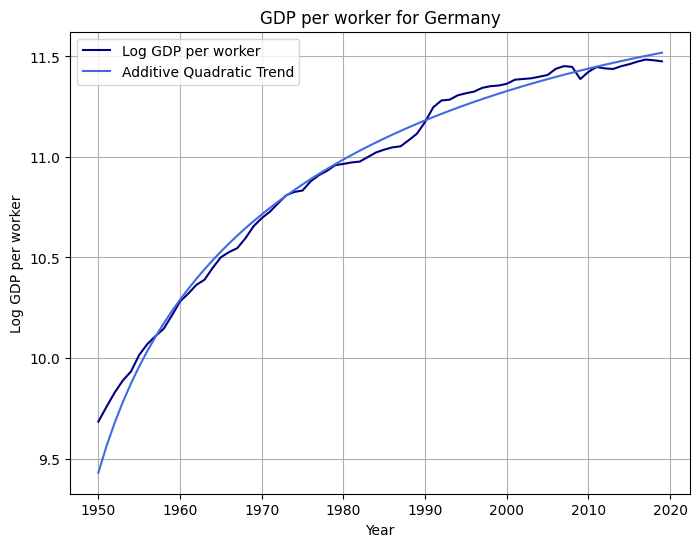

In [10]:
# Plot GDP per worker
fig = plt.figure(figsize = (8, 6))

ax = fig.subplots(1, 1)

ax.plot(df_levels["year"], np.log(df_levels["rgdpna_pw"]), label = "Log GDP per worker", color = "navy")
ax.plot(df_levels["year"], np.log(reg.calc_add_quad(df_levels["rgdpna_pw"])), label = "Additive Quadratic Trend", color = "royalblue")
ax.set_xlabel("Year")
ax.set_ylabel("Log GDP per worker")
ax.set_title("GDP per worker for " + country_selection)
ax.grid()
ax.legend()

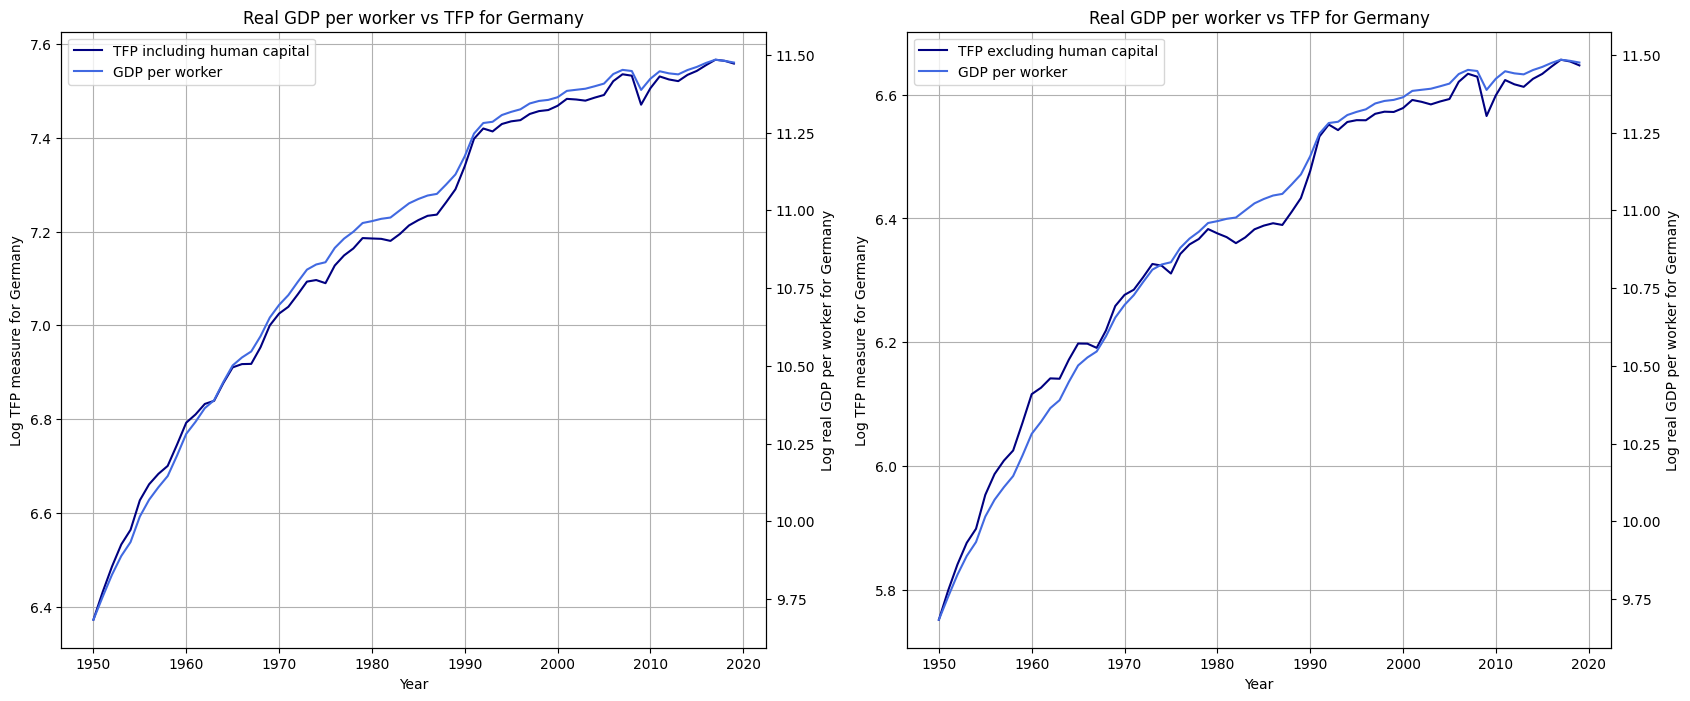

In [11]:
# Create two graphs that compare labour productivity with each TFP measure using a shared x axis.
fig = plt.figure(figsize=(20,8))

ax1, ax2 = fig.subplots(1,2)

ax1.plot(df_levels["year"], np.log(df_levels["TFP_full"]), label="TFP including human capital", color="navy")
ax1.set_ylabel("Log TFP measure for " + country_selection)
ax1.set_xlabel("Year")
ax1.set_title("Real GDP per worker vs TFP for " + country_selection)
ax1.grid(True)

ax3 = ax1.twinx()
ax3.plot(df_levels["year"], np.log(df_levels["rgdpna_pw"]), label="GDP per worker", color="royalblue")
ax3.set_ylabel("Log real GDP per worker for " + country_selection)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)

ax2.plot(df_levels["year"], np.log(df_levels["TFP_ex_hc"]), label="TFP excluding human capital", color="navy")
ax2.set_ylabel("Log TFP measure for " + country_selection)
ax2.set_xlabel("Year")
ax2.set_title("Real GDP per worker vs TFP for " + country_selection)
ax2.grid(True)

ax4 = ax2.twinx()
ax4.plot(df_levels["year"], np.log(df_levels["rgdpna_pw"]), label="GDP per worker", color="royalblue")
ax4.set_ylabel("Log real GDP per worker for " + country_selection)

lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax4.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

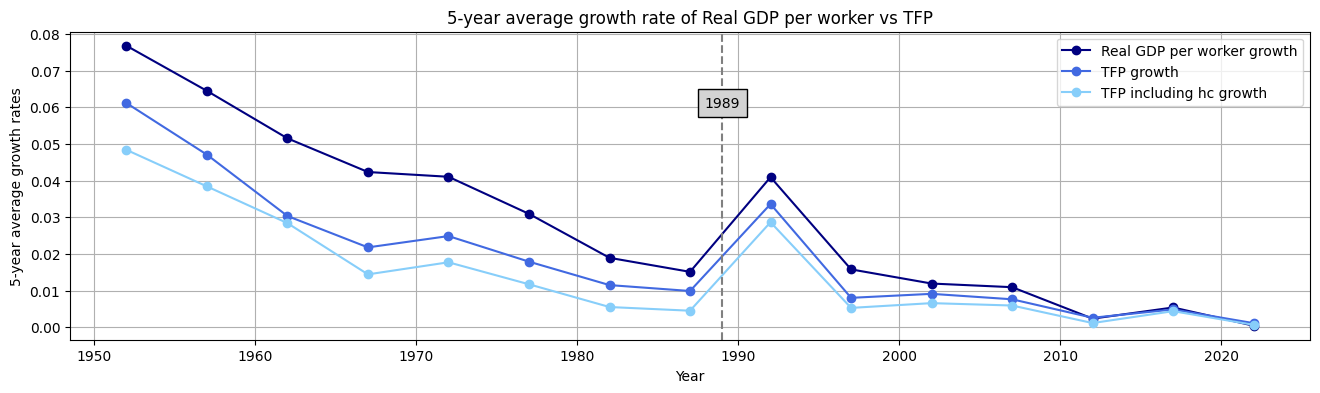

In [12]:
# Plot 5 year average growth rates of all three measures of productivity 
fig = plt.figure(figsize=(16,4))

ax = fig.subplots(1,1)

ax.plot(df_growth_5year.index, df_growth_5year["rgdpna_pw"], label="Real GDP per worker growth", color="navy", marker="o")
ax.plot(df_growth_5year.index, df_growth_5year["TFP_full"], label="TFP growth", color="royalblue", marker="o")
ax.plot(df_growth_5year.index, df_growth_5year["TFP_ex_hc"], label="TFP including hc growth", color="lightskyblue", marker="o")
ax.set_title("5-year average growth rate of Real GDP per worker vs TFP")
ax.set_xlabel("Year")
ax.set_ylabel("5-year average growth rates")
ax.grid(True)
ax.axvline(x=pd.to_datetime(year_of_interest[country_selection]), color="gray", linestyle="--")
ax.text(pd.to_datetime(year_of_interest[country_selection]), 0.06, year_of_interest[country_selection], bbox ={'facecolor':'lightgray','alpha':1,'pad':5}, horizontalalignment = 'center')
ax.legend()

# Growth Accounting 🧾📊

- Absolute growth rates plotted using 5-year averages to get an idea of the long run trend while maintaining detail.
- Contributions of factors plotted to determine which are most important at different periods in time.
- TFP/emp ratio is plotted as theoretically, along the balanced growth path, it should be equal to some constant (assuming the parameters are not chagning).

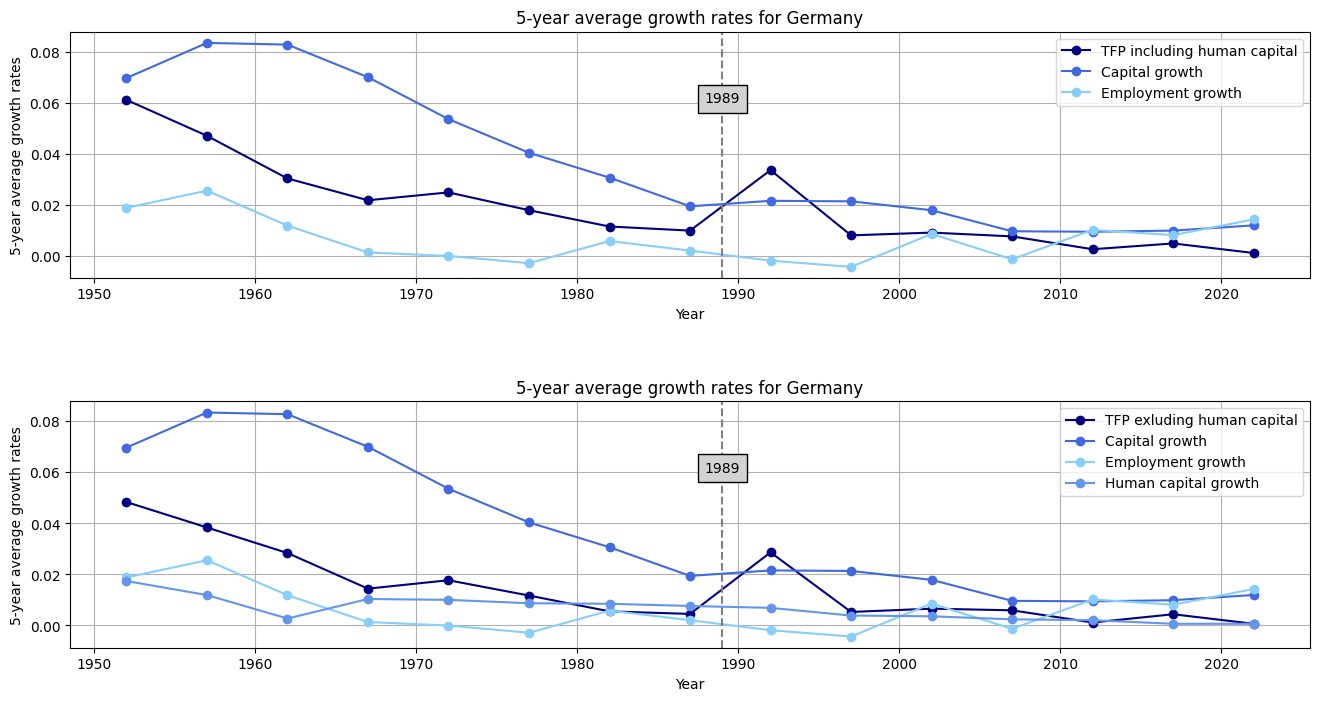

In [13]:
# Plot the growth rates of productivity, capital and employment using 5-year average data
fig = plt.figure(figsize = (16,8))

(ax1, ax2) = fig.subplots(2,1)

ax1.plot(df_growth_5year.index, df_growth_5year["TFP_full"], label="TFP including human capital", color="navy", marker="o")
ax1.plot(df_growth_5year.index, df_growth_5year["rnna"], label="Capital growth", color="royalblue", marker="o")
ax1.plot(df_growth_5year.index, df_growth_5year["emp"], label="Employment growth", color="lightskyblue", marker="o")
ax1.set_title("5-year average growth rates for " + country_selection)
ax1.set_xlabel("Year")
ax1.set_ylabel("5-year average growth rates")
ax1.grid(True)
ax1.axvline(x=pd.to_datetime(year_of_interest[country_selection]), color="gray", linestyle="--")
ax1.text(pd.to_datetime(year_of_interest[country_selection]), 0.06, year_of_interest[country_selection], bbox ={'facecolor':'lightgray','alpha':1,'pad':5}, horizontalalignment = 'center')
ax1.legend()

ax2.plot(df_growth_5year.index, df_growth_5year["TFP_ex_hc"], label="TFP exluding human capital", color="navy", marker="o")
ax2.plot(df_growth_5year.index, df_growth_5year["rnna"], label="Capital growth", color="royalblue", marker="o")
ax2.plot(df_growth_5year.index, df_growth_5year["emp"], label="Employment growth", color="lightskyblue", marker="o")
ax2.plot(df_growth_5year.index, df_growth_5year["hc"], label="Human capital growth", color="cornflowerblue", marker="o")
ax2.set_title("5-year average growth rates for " + country_selection)
ax2.set_xlabel("Year")
ax2.set_ylabel("5-year average growth rates")
ax2.grid(True)
ax2.axvline(x=pd.to_datetime(year_of_interest[country_selection]), color="gray", linestyle="--")
ax2.text(pd.to_datetime(year_of_interest[country_selection]), 0.06, year_of_interest[country_selection], bbox ={'facecolor':'lightgray','alpha':1,'pad':5}, horizontalalignment = 'center')
ax2.legend()

plt.subplots_adjust(hspace=0.5)

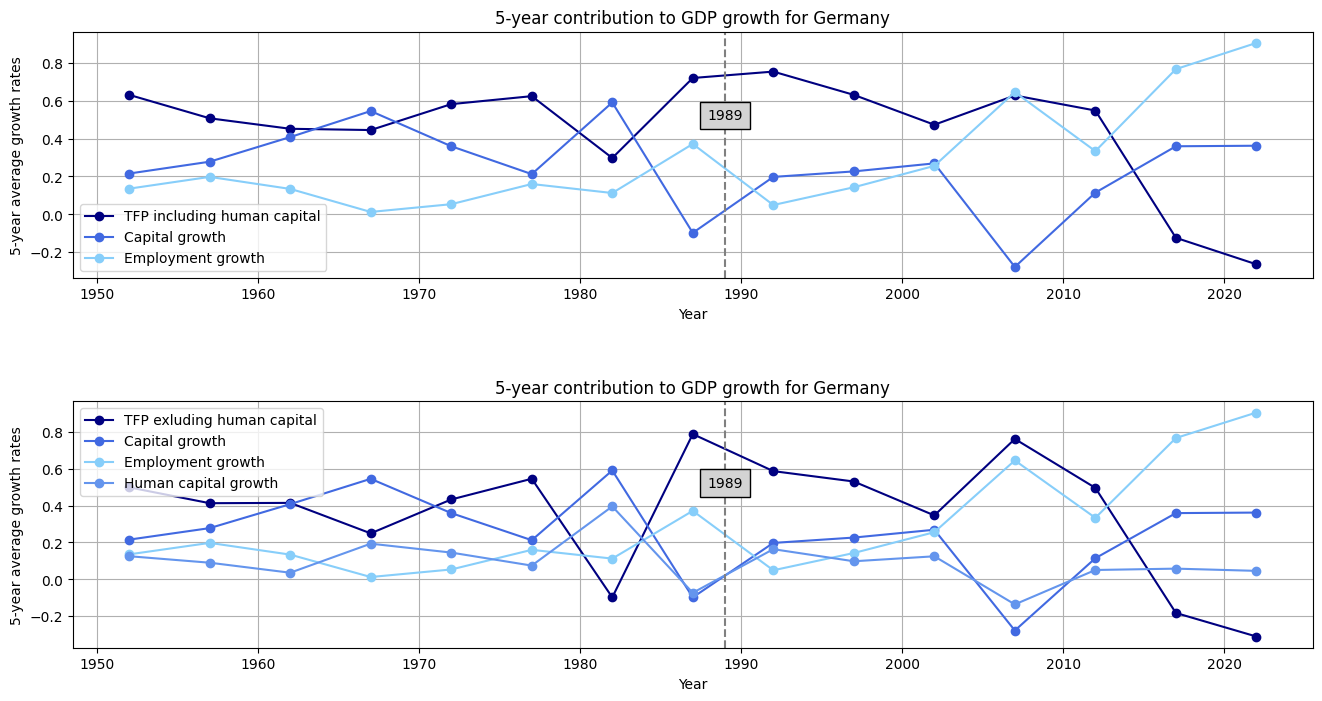

In [14]:
# Plot the contributions of each factor to total GDP growth (robust to different values of alpha)
fig = plt.figure(figsize = (16,8))

(ax1, ax2) = fig.subplots(2,1)

ax1.plot(df_growth_5year.index, df_growth_5year["TFP_full_contribution"], label="TFP including human capital", color="navy", marker="o")
ax1.plot(df_growth_5year.index, df_growth_5year["rnna_contribution"], label="Capital growth", color="royalblue", marker="o")
ax1.plot(df_growth_5year.index, df_growth_5year["emp_contribution"], label="Employment growth", color="lightskyblue", marker="o")
ax1.set_title("5-year contribution to GDP growth for " + country_selection)
ax1.set_xlabel("Year")
ax1.set_ylabel("5-year average growth rates")
ax1.grid(True)
ax1.axvline(x=pd.to_datetime(year_of_interest[country_selection]), color="gray", linestyle="--")
ax1.text(pd.to_datetime(year_of_interest[country_selection]), 0.5, year_of_interest[country_selection], bbox ={'facecolor':'lightgray','alpha':1,'pad':5}, horizontalalignment = 'center')
ax1.legend()

ax2.plot(df_growth_5year.index, df_growth_5year["TFP_ex_hc_contribution"], label="TFP exluding human capital", color="navy", marker="o")
ax2.plot(df_growth_5year.index, df_growth_5year["rnna_contribution"], label="Capital growth", color="royalblue", marker="o")
ax2.plot(df_growth_5year.index, df_growth_5year["emp_contribution"], label="Employment growth", color="lightskyblue", marker="o")
ax2.plot(df_growth_5year.index, df_growth_5year["hc_contribution"], label="Human capital growth", color="cornflowerblue", marker="o")
ax2.set_title("5-year contribution to GDP growth for " + country_selection)
ax2.set_xlabel("Year")
ax2.set_ylabel("5-year average growth rates")
ax2.grid(True)
ax2.axvline(x=pd.to_datetime(year_of_interest[country_selection]), color="gray", linestyle="--")
ax2.text(pd.to_datetime(year_of_interest[country_selection]), 0.5, year_of_interest[country_selection], bbox ={'facecolor':'lightgray','alpha':1,'pad':5}, horizontalalignment = 'center')
ax2.legend()

plt.subplots_adjust(hspace=0.5)

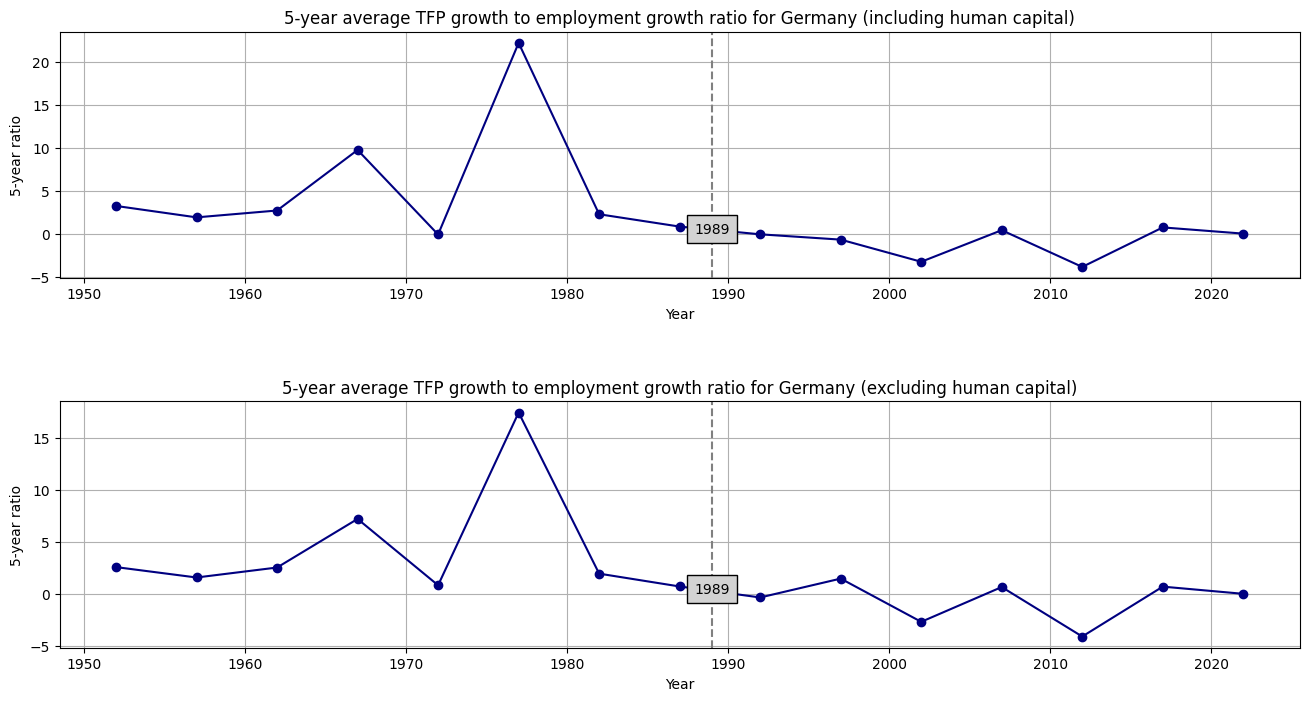

In [15]:
# Plot the TFP/emp ratio
fig = plt.figure(figsize = (16,8))

(ax1, ax2) = fig.subplots(2,1)

ax1.plot(df_growth_5year.index, df_growth_5year["TFP_full_emp_ratio"], color="navy", marker="o")
ax1.set_title("5-year average TFP growth to employment growth ratio for " + country_selection + " (including human capital)")
ax1.set_xlabel("Year")
ax1.set_ylabel("5-year ratio")
ax1.grid(True)
ax1.axvline(x=pd.to_datetime(year_of_interest[country_selection]), color="gray", linestyle="--")
ax1.text(pd.to_datetime(year_of_interest[country_selection]), 0.06, year_of_interest[country_selection], bbox ={'facecolor':'lightgray','alpha':1,'pad':5}, horizontalalignment = 'center')

ax2.plot(df_growth_5year.index, df_growth_5year["TFP_ex_hc_emp_ratio"], color="navy", marker="o")
ax2.set_title("5-year average TFP growth to employment growth ratio for " + country_selection + " (excluding human capital)")
ax2.set_xlabel("Year")
ax2.set_ylabel("5-year ratio")
ax2.grid(True)
ax2.axvline(x=pd.to_datetime(year_of_interest[country_selection]), color="gray", linestyle="--")
ax2.text(pd.to_datetime(year_of_interest[country_selection]), 0.06, year_of_interest[country_selection], bbox ={'facecolor':'lightgray','alpha':1,'pad':5}, horizontalalignment = 'center')

plt.subplots_adjust(hspace=0.5)

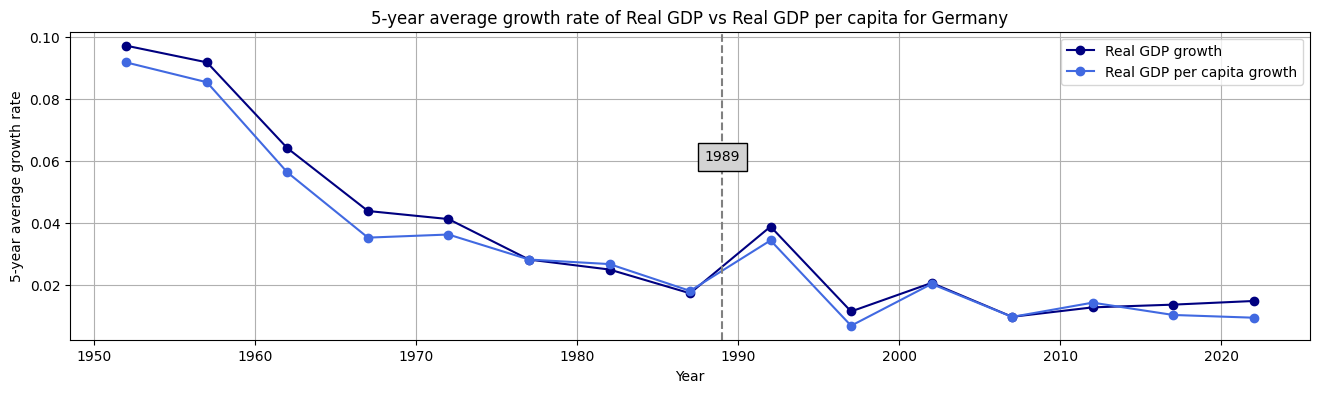

In [16]:
# Plot the average growth rates of real GDP and GDP per capita
fig = plt.figure(figsize=(16,4))

ax = fig.subplots(1,1)

ax.plot(df_growth_5year.index, df_growth_5year["rgdpna"], label="Real GDP growth", color="navy", marker="o")
ax.plot(df_growth_5year.index, df_growth_5year["rgdpna_pc"], label="Real GDP per capita growth", color="royalblue", marker="o")
ax.set_title("5-year average growth rate of Real GDP vs Real GDP per capita for " + country_selection)
ax.set_xlabel("Year")
ax.set_ylabel("5-year average growth rate")
ax.grid(True)
ax.axvline(x=pd.to_datetime(year_of_interest[country_selection]), color="gray", linestyle="--")
ax.text(pd.to_datetime(year_of_interest[country_selection]), 0.06, year_of_interest[country_selection], bbox ={'facecolor':'lightgray','alpha':1,'pad':5}, horizontalalignment = 'center')
ax.legend()

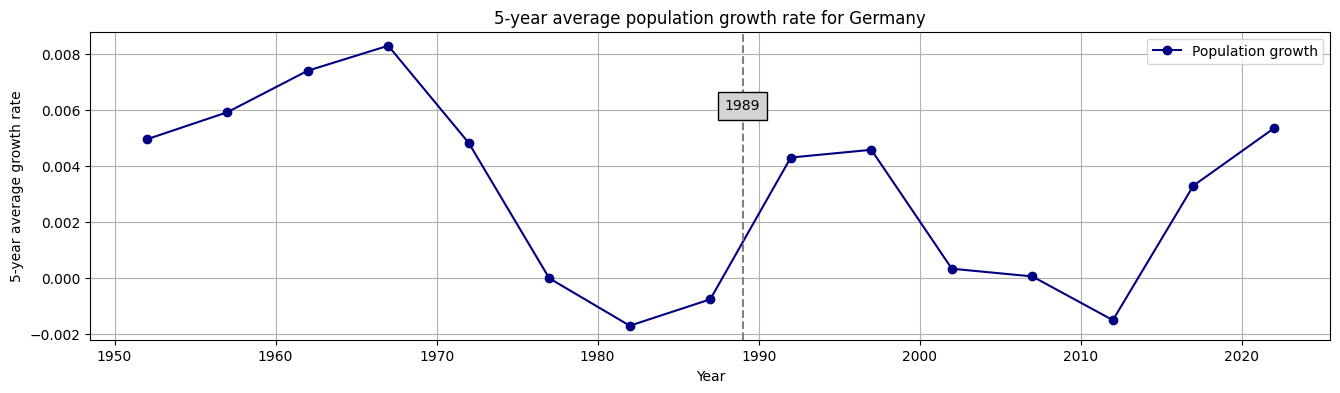

In [18]:
# Plot the average growth rate of population
fig = plt.figure(figsize=(16,4))

ax = fig.subplots(1,1)

ax.plot(df_growth_5year.index, df_growth_5year["pop"], label="Population growth", color="navy", marker="o")
ax.set_title("5-year average population growth rate for " + country_selection)
ax.set_xlabel("Year")
ax.set_ylabel("5-year average growth rate")
ax.grid(True)
ax.axvline(x=pd.to_datetime(year_of_interest[country_selection]), color="gray", linestyle="--")
ax.text(pd.to_datetime(year_of_interest[country_selection]), 0.006, year_of_interest[country_selection], bbox ={'facecolor':'lightgray','alpha':1,'pad':5}, horizontalalignment = 'center')
ax.legend()